[View in Colaboratory](https://colab.research.google.com/github/aunz/ds/blob/master/Modeling_interaction.ipynb)


Given a non-linear function, such as $y = \beta_0 + \beta_1 * x_1 + \beta_2 * x_2 + \beta_{12} * x_1 * x_2 + noise$, where we have some intereaction between X1 and X2

What are the options to model $y \sim X$


## Data
We create some random data and group them into 3 sets: train, validation and test

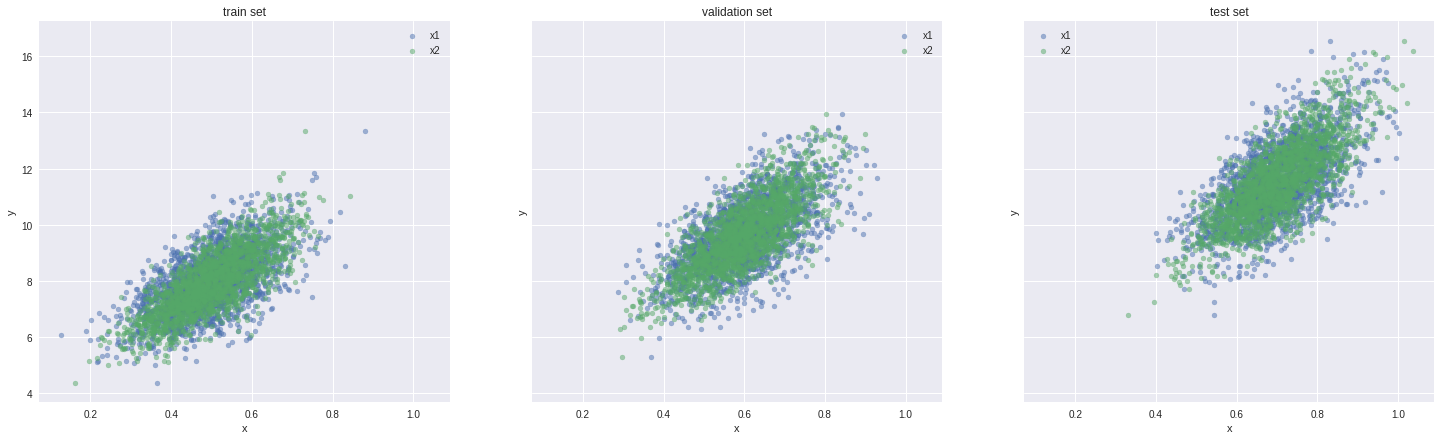

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


np.random.seed(0)

def make_y(X, noise=True):
    # given X features, create y target
    x1 = X[:, 0]
    x2 = X[:, 1]
    y = 2 + 3 * x1 + 5 * x2 + 8 * x1 * x2
    if noise: y += 0.1 * np.random.randn(len(X))
    return y

# create a train set with random number normally distributed with mean of 0.5 and standard deviation of 0.1
X_train = 0.1 * np.random.randn(2000, 2) + 0.5
y_train = make_y(X_train)

# similarly for a validation set
X_val = 0.1 * np.random.randn(2000, 2) + 0.6
y_val = make_y(X_val)

# finally for a test set
X_test = 0.1 * np.random.randn(2000, 2) + 0.7
y_test = make_y(X_test)

# plot them
fig, axs = plt.subplots(1, 3, figsize=(25, 7), sharex=True, sharey=True)
for ax, X, y, title in zip(axs, (X_train, X_val, X_test), (y_train, y_val, y_test), ('train set', 'validation set', 'test set')):
    ax.scatter(X[:, 0], y, s=25, alpha=0.5, label='x1')
    ax.scatter(X[:, 1], y, s=25, alpha=0.5, label='x2')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)
    ax.legend() 

Then define a scoring method. In this case we use root mean square error.

The algorithms we are going to test:
- Linear regression

In [167]:
from sklearn.metrics import mean_squared_error

# define a scoring method, just root mean square error here
def score(preds, y_true = y_test, title='Test set', plot=True):
    if plot:
        plt.plot([4, 16], [4, 16], c='silver', alpha=0.25)
        plt.scatter(preds, y_true, alpha=0.5, s=10)
        plt.plot([4, 4], [16, 16])
        plt.xlabel('Predicted y')
        plt.ylabel('True y')
        plt.title(title)
    return mean_squared_error(y_true, preds) ** .5


# store scores in a data frame for later summary
scores = pd.DataFrame(columns=['train', 'val', 'test'])


# the best possible rmse, determined by removing the noise
scores.loc['best',:] = [
    score(y_train, make_y(X_train, False), plot=False),
    score(y_val, make_y(X_val, False), plot=False),
    score(y_test, make_y(X_test, False), plot=False)
]

scores

,train,val,test
best,0.0997265,0.101577,0.0966925


## Linear regression

Our first model

We expect that linear regression is not able to capture the interaction using the default settings

intercept: -0.012821285932014703
coef: [7.01848067 9.00683918]


,train,val,test
linear regression,0.126593,0.191076,0.410115


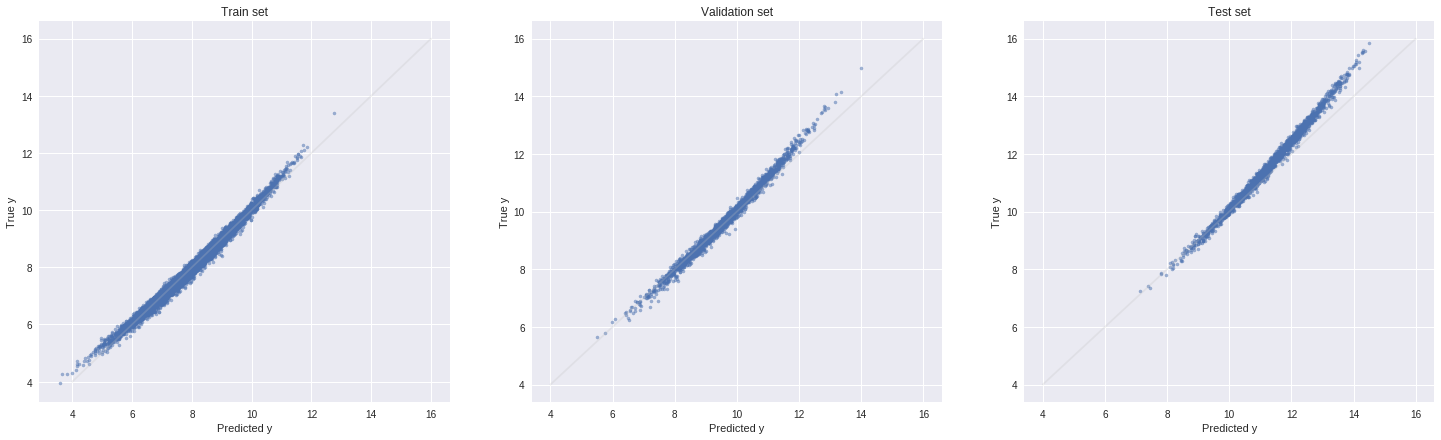

In [168]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)
print('intercept:', reg.intercept_)
print('coef:', reg.coef_)

plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
s1 = score(reg.predict(X_train), y_train, 'Train set')
plt.subplot(1, 3, 2)
s2 = score(reg.predict(X_val), y_val, 'Validation set')
plt.subplot(1, 3, 3)
s3 = score(reg.predict(X_test), y_test)

scores.loc['linear regression',:] = [s1, s2, s3]
scores.iloc[[-1]]

intercept: 1.9863595779142402
coef: [3.00931949 5.01960111 7.99446344]


,train,val,test
linear regression with intereaction,0.0997089,0.101679,0.0968133


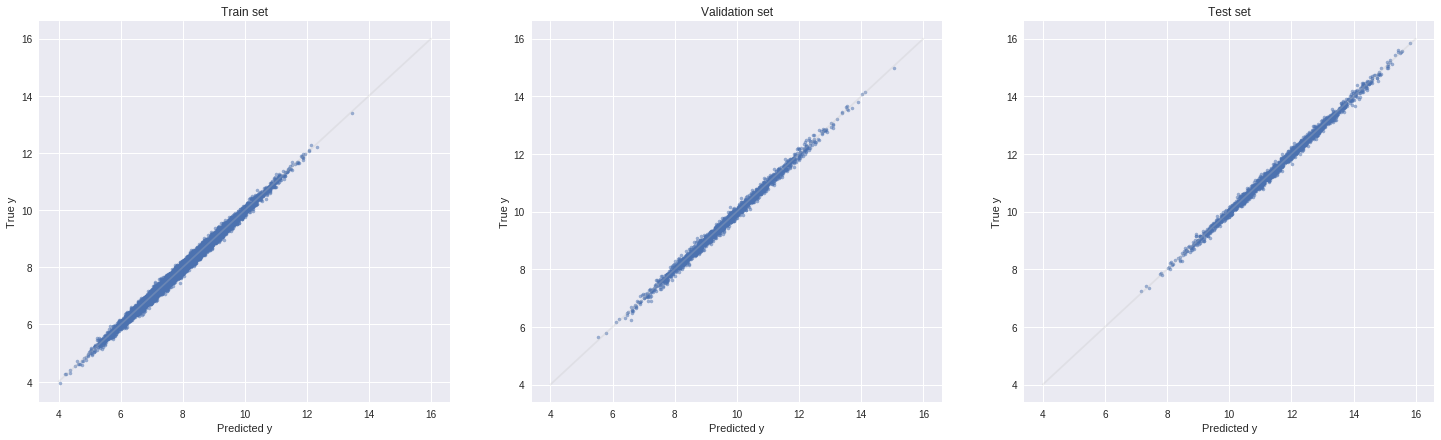

In [169]:
# when we allow intereaction

reg = LinearRegression()
reg.fit(np.column_stack([X_train, X_train[:,0] * X_train[:, 1]]), y_train) # add another column (feature) composed of x1 * x2
print('intercept:', reg.intercept_)
print('coef:', reg.coef_)

plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
s1 = score(reg.predict(np.column_stack([X_train, X_train[:,0] * X_train[:, 1]])), y_train, 'Train set')
plt.subplot(1, 3, 2)
s2 = score(reg.predict(np.column_stack([X_val, X_val[:,0] * X_val[:, 1]])), y_val, 'Validation set')
plt.subplot(1, 3, 3)
s3 = score(reg.predict(np.column_stack([X_test, X_test[:,0] * X_test[:, 1]])), y_test)

scores.loc['linear regression with intereaction',:] = [s1, s2, s3]
scores.iloc[[-1]]

,train,val,test
svm,0.110778,0.197381,0.515832


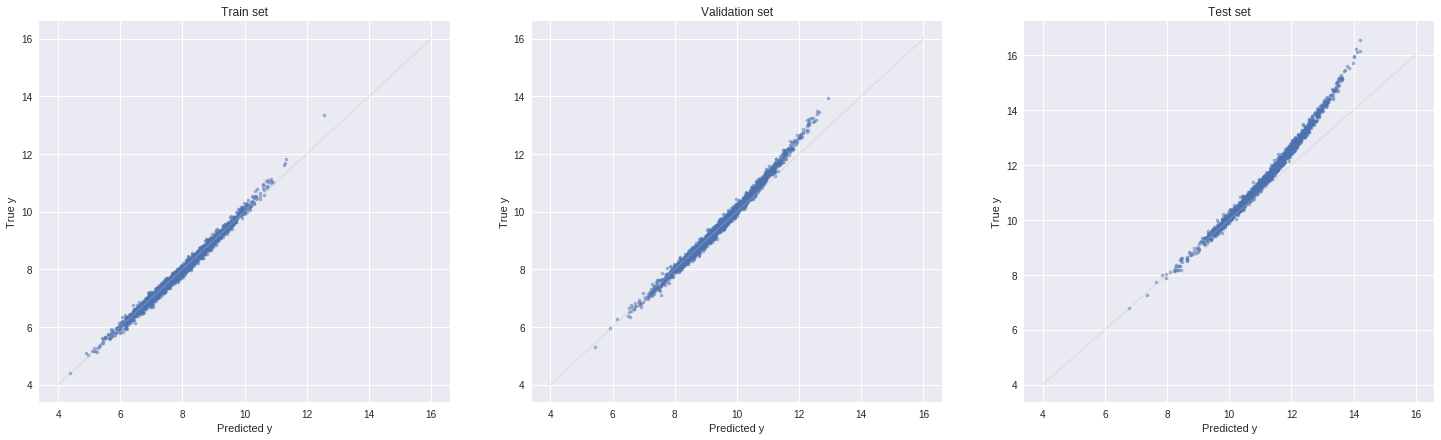

In [32]:
from sklearn import svm

reg = svm.SVR()
reg.fit(X_train, y_train)

plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
s1 = score(reg.predict(X_train), y_train, 'Train set')
plt.subplot(1, 3, 2)
s2 = score(reg.predict(X_val), y_val, 'Validation set')
plt.subplot(1, 3, 3)
s3 = score(reg.predict(X_test), y_test)

scores.loc['svm',:] = [s1, s2, s3]
scores.iloc[[-1]]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


,train,val,test
SGD regressor,0.690212,1.29616,2.4487


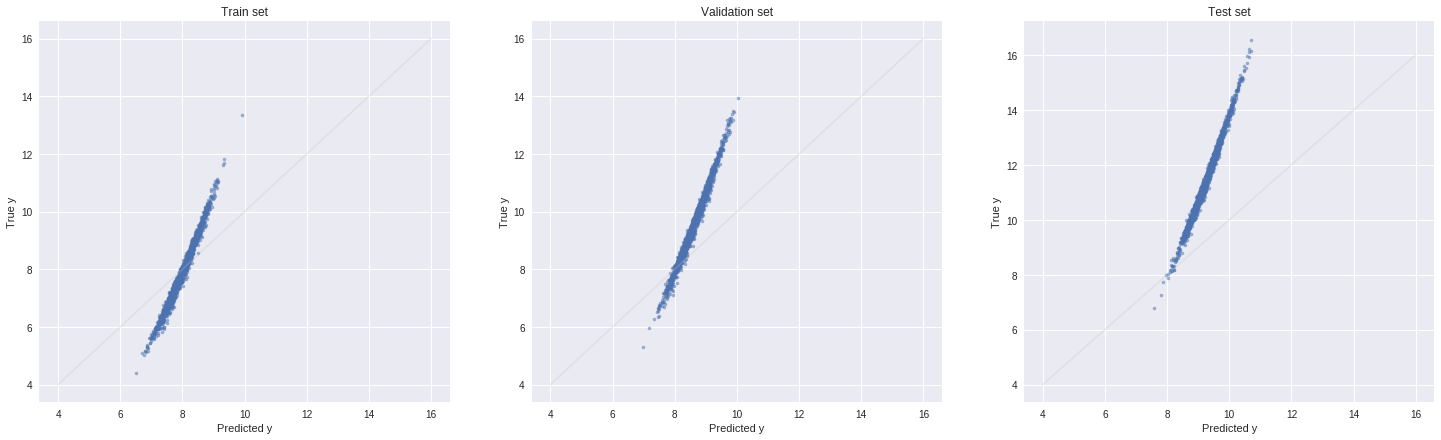

In [33]:
from sklearn.linear_model import SGDRegressor

reg = SGDRegressor()
reg.fit(X_train, y_train)

plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
s1 = score(reg.predict(X_train), y_train, 'Train set')
plt.subplot(1, 3, 2)
s2 = score(reg.predict(X_val), y_val, 'Validation set')
plt.subplot(1, 3, 3)
s3 = score(reg.predict(X_test), y_test)

scores.loc['SGD regressor',:] = [s1, s2, s3]
scores.iloc[[-1]]

,train,val,test
"knn, k = 5",0.106798,0.307,1.0142


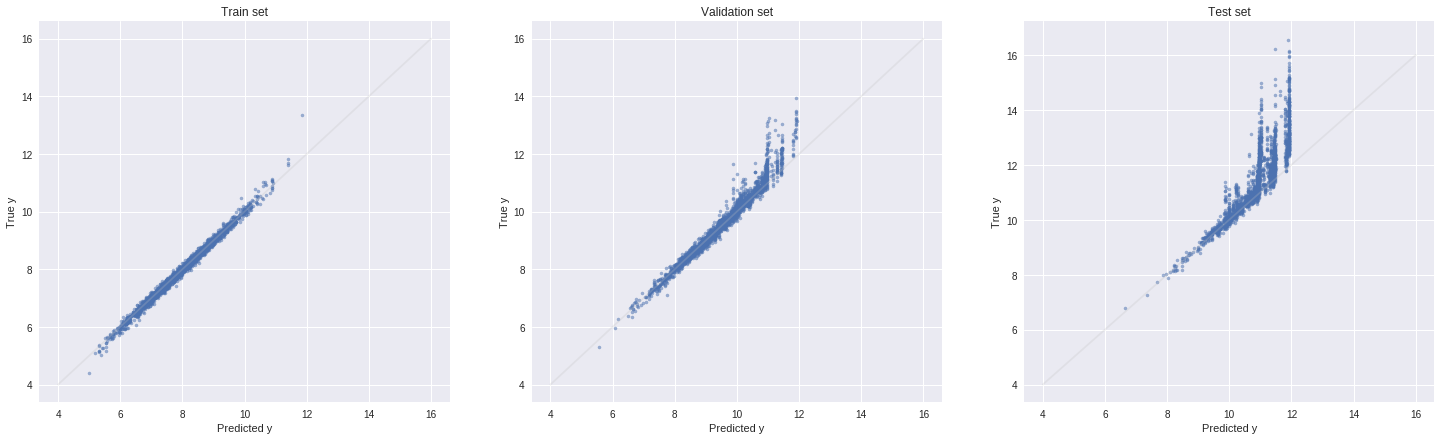

In [34]:
from sklearn.neighbors import KNeighborsRegressor

reg = KNeighborsRegressor()
reg.fit(X_train, y_train)

plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
s1 = score(reg.predict(X_train), y_train, 'Train set')
plt.subplot(1, 3, 2)
s2 = score(reg.predict(X_val), y_val, 'Validation set')
plt.subplot(1, 3, 3)
s3 = score(reg.predict(X_test), y_test)

scores.loc['knn, k = 5',:] = [s1, s2, s3]
scores.iloc[[-1]]

,train,val,test
"knn, k = 2",0.139144,0.438521,1.37781


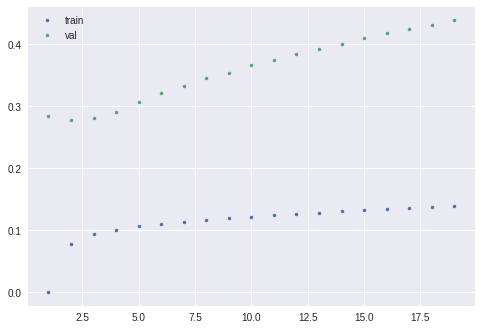

In [222]:
# tuning for k

score_train = []
score_val = []

for i in range(1, 20):
    reg = KNeighborsRegressor(i)
    reg.fit(X_train, y_train)
    score_train.append(score(reg.predict(X_train), y_train, plot=False))
    score_val.append(score(reg.predict(X_val), y_val, plot=False))
    
plt.plot(range(1, 20), score_train, '.', label='train')
plt.plot(range(1, 20), score_val, '.', label='val')
plt.legend();

# k = 2 seems the best
scores.loc['knn, k = 2',:] = [
    score(reg.predict(X_train), y_train, 'Train set', plot=False),
    score(reg.predict(X_val), y_val, 'Train set', plot=False),
    score(reg.predict(X_test), y_test, 'Train set', plot=False)
]
scores.iloc[[-1]]

,train,val,test
"Random Forest, default",0.0590276,0.273555,0.832791


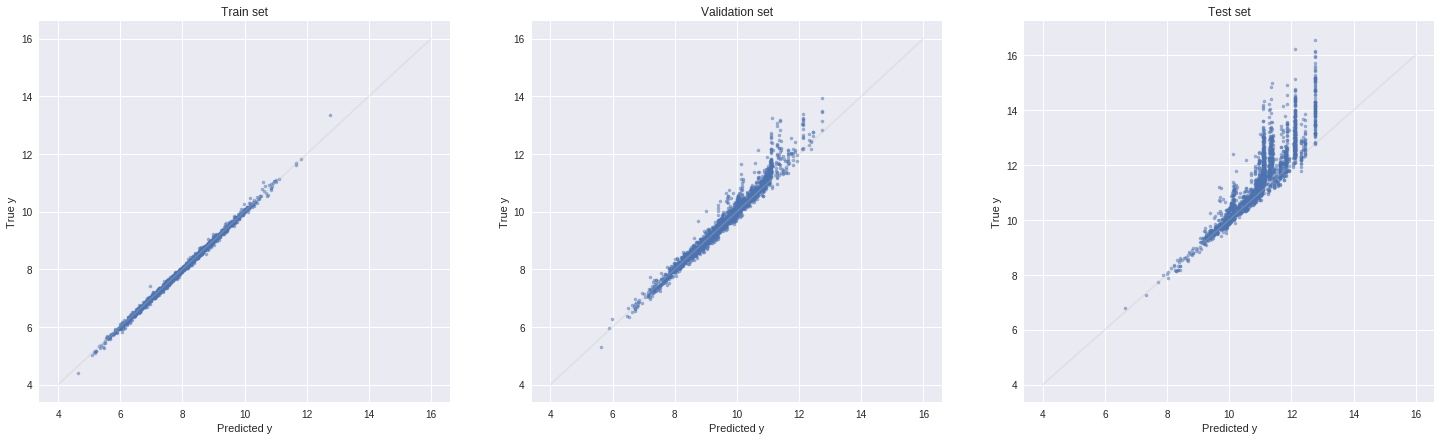

In [35]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()
reg.fit(X_train, y_train)

plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
s1 = score(reg.predict(X_train), y_train, 'Train set')
plt.subplot(1, 3, 2)
s2 = score(reg.predict(X_val), y_val, 'Validation set')
plt.subplot(1, 3, 3)
s3 = score(reg.predict(X_test), y_test)

scores.loc['Random Forest',:] = [s1, s2, s3]
scores.iloc[[-1]]

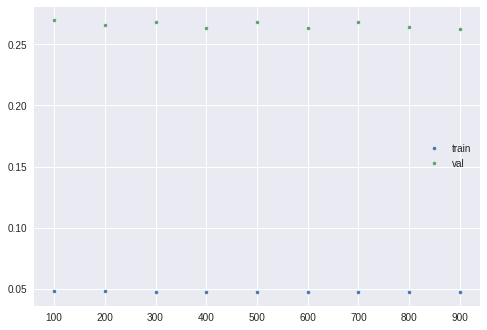

In [36]:
# tuning for random forest

score_train = []
score_val = []
ranges = range(100, 1000, 100)

for i in ranges:
    reg = RandomForestRegressor(n_estimators=i)
    reg.fit(X_train, y_train)
    score_train.append(score(reg.predict(X_train), y_train, plot=False))
    score_val.append(score(reg.predict(X_val), y_val, plot=False))
    
plt.plot(ranges, score_train, '.', label='train')
plt.plot(ranges, score_val, '.', label='val')
plt.legend();

# doesn't look like n_estimators make any difference

,train,val,test
MLPRegressor,0.133184,0.335642,0.951994


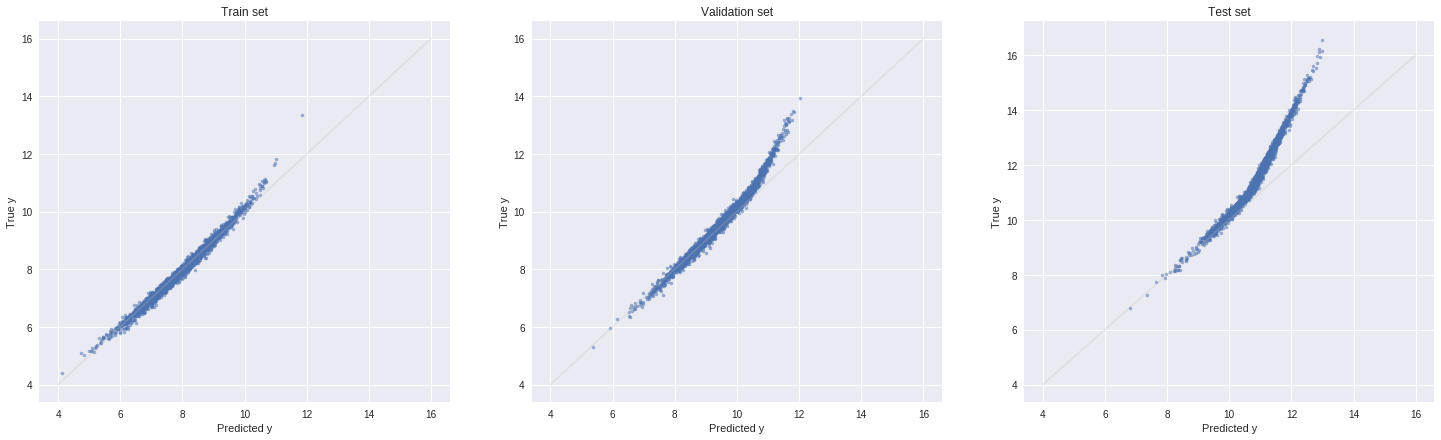

In [37]:
from sklearn.neural_network import MLPRegressor

reg = MLPRegressor()
reg.fit(X_train, y_train)

plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
s1 = score(reg.predict(X_train), y_train, 'Train set')
plt.subplot(1, 3, 2)
s2 = score(reg.predict(X_val), y_val, 'Validation set')
plt.subplot(1, 3, 3)
s3 = score(reg.predict(X_test), y_test)

scores.loc['MLPRegressor',:] = [s1, s2, s3]
scores.iloc[[-1]]

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

earlyStopping = [EarlyStopping(patience=5, verbose=1)]

np.random.seed(0)

model = Sequential()
model.add(Dense(1, input_shape=(2,))) # 1 input layer, 1 output, no activation, so this is essentially similar to linear regression
         
model.summary()
model.compile(loss='mse', optimizer='sgd')
model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), callbacks=earlyStopping, verbose=0)

plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
s1 = score(model.predict(X_train), y_train, 'Train set')
plt.subplot(1, 3, 2)
s2 = score(model.predict(X_val), y_val, 'Validation set')
plt.subplot(1, 3, 3)
s3 = score(model.predict(X_test), y_test)

scores.loc['NN ',:] = [s1, s2, s3]
scores.iloc[[-1]]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 00046: early stopping


  6%|▌         | 1/18 [00:10<02:54, 10.27s/it]

Epoch 00052: early stopping


 11%|█         | 2/18 [00:21<02:48, 10.51s/it]

Epoch 00036: early stopping


 17%|█▋        | 3/18 [00:30<02:30, 10.02s/it]

Epoch 00042: early stopping


 22%|██▏       | 4/18 [00:40<02:19,  9.95s/it]

Epoch 00042: early stopping


 28%|██▊       | 5/18 [00:49<02:08,  9.92s/it]

Epoch 00055: early stopping


 33%|███▎      | 6/18 [01:01<02:05, 10.45s/it]

Epoch 00067: early stopping


 39%|███▉      | 7/18 [01:14<02:04, 11.31s/it]

Epoch 00047: early stopping


 44%|████▍     | 8/18 [01:25<01:51, 11.13s/it]

Epoch 00054: early stopping


 50%|█████     | 9/18 [01:37<01:41, 11.29s/it]

Epoch 00058: early stopping


 56%|█████▌    | 10/18 [01:49<01:32, 11.59s/it]

Epoch 00041: early stopping


 61%|██████    | 11/18 [01:59<01:17, 11.12s/it]

Epoch 00043: early stopping


 67%|██████▋   | 12/18 [02:09<01:05, 10.87s/it]

Epoch 00041: early stopping


 72%|███████▏  | 13/18 [02:19<00:53, 10.61s/it]

Epoch 00050: early stopping


 78%|███████▊  | 14/18 [02:31<00:43, 10.85s/it]

Epoch 00040: early stopping


 83%|████████▎ | 15/18 [02:41<00:31, 10.61s/it]

Epoch 00035: early stopping


 89%|████████▉ | 16/18 [02:50<00:20, 10.24s/it]

Epoch 00039: early stopping


 94%|█████████▍| 17/18 [03:00<00:10, 10.21s/it]

Epoch 00046: early stopping


100%|██████████| 18/18 [03:12<00:00, 10.68s/it]


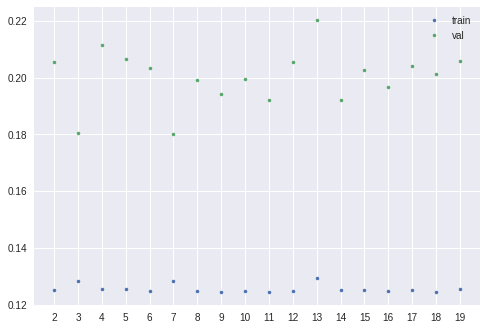

In [135]:
# tuning for number of neurons in the first layer
from tqdm import tqdm # for progress bar

score_train = []
score_val = []
ranges = range(2, 20)

for i in tqdm(ranges):
    model = Sequential()
    model.add(Dense(i, input_shape=(2,)))
    model.add(Dense(1))
         
    model.compile(loss='mse', optimizer='sgd')
    model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), callbacks=earlyStopping, verbose=0)
    
    score_train.append(score(model.predict(X_train), y_train, plot=False))
    score_val.append(score(model.predict(X_val), y_val, plot=False))
    
plt.plot(ranges, score_train, '.', label='train', )
plt.plot(ranges, score_val, '.', label='val')
plt.xticks(ranges)
plt.legend();

# look like 2 neurons are enough. But why such high errors at 4

Epoch 00221: early stopping


,train,val,test
NN D4 D4,0.103688,0.129021,0.221228


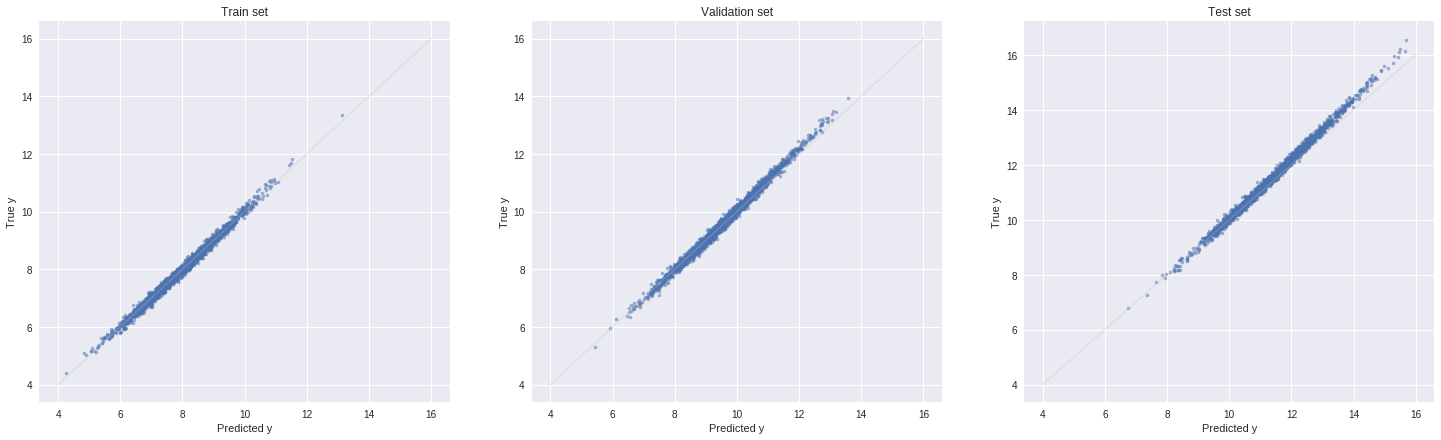

In [190]:
# trying 2 neurons
from keras import optimizers

model = Sequential()
model.add(Dense(1, input_shape=(3,)))
# model.add(Dense(3))
# model.add(Dropout(0.25))
# model.add(Dense(1))

# opt = optimizers.SGD(lr=0.001)
# opt = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
# opt = optimizers.RMSprop()
# opt = optimizers.Adagrad()
# opt = optimizers.Adadelta()
# opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
# opt = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
# opt = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
# model.compile(loss='mse', optimizer=opt)

model.compile(loss='mae', optimizer='sgd')
# model.fit(X_train, (y_train), epochs=1000, validation_data=(X_val, (y_val)), callbacks=earlyStopping, verbose=0)
model.fit(np.column_stack([X_train, X_train[:,0] * X_train[:, 1]]), y_train, epochs=1000, validation_data=(np.column_stack([X_train, X_train[:,0] * X_train[:, 1]]), y_train), callbacks=earlyStopping, verbose=0)

plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
s1 = score(model.predict(np.column_stack([X_train, X_train[:,0] * X_train[:, 1]])), y_train, 'Train set')
plt.subplot(1, 3, 2)
s2 = score(model.predict(np.column_stack([X_val, X_val[:,0] * X_val[:, 1]])), y_val, 'Validation set')
plt.subplot(1, 3, 3)
s3 = score(model.predict(np.column_stack([X_test, X_test[:,0] * X_test[:, 1]])), y_test)

scores.loc['NN D4 D4',:] = [s1, s2, s3]
scores.iloc[[-1]]
# scores

In [191]:
model.get_weights()
# plt.hist(np.log(y_train), 100);

[array([[4.5575857],
        [6.518181 ],
        [4.779132 ]], dtype=float32), array([1.2625152], dtype=float32)]



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 00026: early stopping




 25%|██▌       | 1/4 [00:05<00:17,  5.75s/it]

Epoch 00006: early stopping




 50%|█████     | 2/4 [00:09<00:10,  5.08s/it]

Epoch 00015: early stopping




 75%|███████▌  | 3/4 [00:13<00:04,  4.97s/it]

Epoch 00022: early stopping




100%|██████████| 4/4 [00:19<00:00,  5.20s/it]

                                             

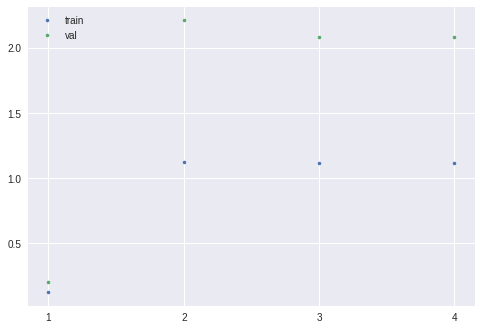

In [253]:
# tuning for number of hidden layer

from tqdm import tqdm # for progress bar

score_train = []
score_val = []
ranges = range(1, 5)

for i in tqdm(ranges, leave=False):
    model = Sequential()
    model.add(Dense(4, input_shape=(2,), activation='relu'))
    for j in range(i): model.add(Dense(4, activation='relu')) # hidden layer, just 2 neurons
    model.add(Dense(1))
         
    model.compile(loss='mean_squared_error', optimizer='sgd')
    model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), callbacks=earlyStopping, verbose=0)
    
    score_train.append(score(model.predict(X_train), y_train, plot=False))
    score_val.append(score(model.predict(X_val), y_val, plot=False))
    
plt.plot(ranges, score_train, '.', label='train', )
plt.plot(ranges, score_val, '.', label='val')
plt.xticks(ranges)
plt.legend();

In [0]:
np.random.seed(0)

model = Sequential()
model.add(Dense(2, input_shape=(2,), activation='relu'))
model.add(Dense(1))
          
model.summary()

model.compile(loss='mean_squared_error', optimizer='sgd')

model.fit(X_train, y_train, epochs=1000, callbacks=earlyStopping, verbose=0)

score(model.predict(X_train), y_train), score(model.predict(x[test]))

In [0]:
np.random.seed(0)

model = Sequential()
model.add(Dense(2, input_shape=(2,), activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1))
          
model.summary()

model.compile(loss='mean_squared_error', optimizer='sgd')

model.fit(X_train, y_train, epochs=1000, callbacks=earlyStopping, verbose=0)

score(model.predict(X_train), y_train), score(model.predict(x[test]))

In [0]:
np.random.seed(0)

model = Sequential()
model.add(Dense(4, input_shape=(2,), activation='relu'))
model.add(Dense(1))
          
model.summary()

model.compile(loss='mean_squared_error', optimizer='sgd')

model.fit(X_train, y_train, epochs=1000, callbacks=earlyStopping, verbose=0)

score(model.predict(X_train), y_train), score(model.predict(x[test]))


In [0]:
np.random.seed(0)

model = Sequential()
model.add(Dense(2, input_shape=(2,), activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))
          
model.summary()

model.compile(loss='mean_squared_error', optimizer='sgd')

model.fit(X_train, y_train, epochs=1000, callbacks=earlyStopping, verbose=0)

score(model.predict(X_train), y_train), score(model.predict(x[test]))

In [0]:
np.random.seed(0)

model = Sequential()
model.add(Dense(16, input_shape=(2,), activation='relu'))
model.add(Dense(8, activation='relu'))
# model.add(Dense(8, activation='relu'))
model.add(Dense(1))
          
model.summary()

model.compile(loss='mean_squared_error', optimizer='sgd')

hist = model.fit(X_train, y_train, epochs=100, validation_data=(x[test], y[test]))

score(model.predict(X_train), y_train), score(model.predict(x[test]))